In [20]:
%pip install torcheval
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [21]:
import os
from dataclasses import dataclass
import glob
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.optim import AdamW, Optimizer
from torchvision import transforms
from torcheval.metrics.functional import multiclass_f1_score
from torchinfo import summary
from PIL import Image
import torch
from torch import nn
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
labeled_imgs = glob.glob("data/train/*/*.jpg", recursive=True)

In [24]:
len(labeled_imgs)

2746

In [25]:
def parse_label(img_path: str) -> str:
    path_chucks = img_path.split("\\")  # Changed from "/" to "\\" for Windows
    return path_chucks[-2]

# Test with your local path structure
parse_label('data\\train\\dandelion\\16242239484_51286673af.jpg')

'dandelion'

In [26]:
labeled_imgs[:5]

['data/train\\daisy\\10140303196_b88d3d6cec.jpg',
 'data/train\\daisy\\10172379554_b296050f82_n.jpg',
 'data/train\\daisy\\10172567486_2748826a8b.jpg',
 'data/train\\daisy\\10172636503_21bededa75_n.jpg',
 'data/train\\daisy\\10391248763_1d16681106_n.jpg']

In [27]:
labeled_imgs_df = pd.DataFrame(data = {"path": labeled_imgs})\
    .assign(label = lambda df_: df_.path.apply(parse_label))
labeled_imgs_df.head()

,path,label
0,data/train\daisy\10140303196_b88d3d6cec.jpg,daisy
1,data/train\daisy\10172379554_b296050f82_n.jpg,daisy
2,data/train\daisy\10172567486_2748826a8b.jpg,daisy
3,data/train\daisy\10172636503_21bededa75_n.jpg,daisy
4,data/train\daisy\10391248763_1d16681106_n.jpg,daisy


In [28]:
labeled_imgs_df\
    .label\
    .value_counts()\
    .to_frame()\
    .rename(columns = {"count": "n_records"})\
    .assign(share = lambda df_: df_.n_records / df_.n_records.sum())\
    .style\
        .format({"share":"{:,.1%}"})

,n_records,share
label,,
dandelion,646,23.5%
tulip,607,22.1%
daisy,501,18.2%
rose,497,18.1%
sunflower,495,18.0%


# Train/validation/test split

In [29]:
def rnd_to_dataset_mapping(rand: float) -> str:
    if rand < .6:
        return "train"
    elif .6 <= rand < .8:
        return "val"
    else:
        return "test"

np.random.seed(42)
labeled_imgs_df = labeled_imgs_df\
    .assign(random_number = np.random.rand(len(labeled_imgs_df)))\
    .assign(dataset = lambda df_: df_.random_number.apply(rnd_to_dataset_mapping))

labeled_imgs_df.head()

,path,label,random_number,dataset
0,data/train\daisy\10140303196_b88d3d6cec.jpg,daisy,0.374540,train
1,data/train\daisy\10172379554_b296050f82_n.jpg,daisy,0.950714,test
2,data/train\daisy\10172567486_2748826a8b.jpg,daisy,0.731994,val
3,data/train\daisy\10172636503_21bededa75_n.jpg,daisy,0.598658,train
4,data/train\daisy\10391248763_1d16681106_n.jpg,daisy,0.156019,train


In [30]:
labeled_imgs_df\
    .groupby(["label", "dataset"])\
    .path\
    .count()\
    .to_frame()\
    .rename(columns = {'path': 'n_records'})\
    .reset_index()\
    .pivot(
        index = 'label',
        columns = 'dataset',
        values = 'n_records'
    )\
    .loc[:, ['train', 'val', 'test']]

dataset,train,val,test
label,,,
daisy,293,102,106
dandelion,400,114,132
rose,282,116,99
sunflower,291,108,96
tulip,364,126,117


# Datasets

In [31]:
class ImageDataset(Dataset):
    def __init__(self, label_df, transform=None):
        self.paths = label_df["path"].to_numpy()
        self.class_names = sorted(label_df["label"].unique().tolist())
        self.class_to_idx = {c:i for i,c in enumerate(self.class_names)}
        self.y = label_df["label"].map(self.class_to_idx).astype("int64").to_numpy()
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i: int):
        img = Image.open(self.paths[i]).convert("RGB")
        x = self.transform(img)
        y = torch.tensor(self.y[i], dtype=torch.long)   # <- correct form
        return x, y

In [32]:
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

train_dataset = ImageDataset(
    label_df = labeled_imgs_df.query("dataset == 'train'"),
    transform = basic_transforms
)

val_dataset = ImageDataset(
    label_df = labeled_imgs_df.query("dataset == 'val'"),
    transform = basic_transforms
)

test_dataset = ImageDataset(
    label_df = labeled_imgs_df.query("dataset == 'test'"),
    transform = basic_transforms
)

print(train_dataset)

In [33]:
class_names = train_dataset.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [34]:
print(f"Train records,      # {len(train_dataset)}")
print(f"Validation records, # {len(val_dataset)}")
print(f"Test records,       # {len(test_dataset)}")

Train records,      # 1630
Validation records, # 566
Test records,       # 550


In [35]:
train_dataset[0]

(tensor([[[ 1.5125,  1.4612,  1.4783,  ..., -1.9638, -1.9295, -1.9809],
          [ 1.5810,  1.5810,  1.5639,  ..., -1.9467, -1.9295, -1.9809],
          [ 1.6153,  1.6153,  1.6667,  ..., -1.9638, -1.9980, -2.0152],
          ...,
          [ 1.3584,  1.4612,  1.5468,  ...,  0.8789,  1.0159,  0.9303],
          [ 1.7009,  1.7009,  1.6667,  ...,  0.8961,  0.9817,  0.8447],
          [ 1.8037,  1.7694,  1.7694,  ...,  0.9132,  1.0159,  0.8618]],
 
         [[ 1.7283,  1.7108,  1.6933,  ..., -1.8606, -1.8782, -1.8957],
          [ 1.8158,  1.8158,  1.7458,  ..., -1.8606, -1.8782, -1.8957],
          [ 1.7983,  1.7983,  1.8859,  ..., -1.8957, -1.9132, -1.9132],
          ...,
          [ 1.6057,  1.6933,  1.8158,  ...,  0.8880,  1.0105,  0.8880],
          [ 1.9384,  1.9034,  1.9209,  ...,  0.9055,  0.9755,  0.8529],
          [ 2.0084,  1.9909,  2.0084,  ...,  0.9055,  0.9580,  0.7829]],
 
         [[ 2.0823,  2.0300,  2.0474,  ..., -1.5604, -1.5430, -1.5779],
          [ 2.1520,  2.1346,

In [36]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

# Loaders

In [37]:
def show_model_input(dataset):
    dataiter_check = iter(dataset)

    for _ in range(5):
        images, labels = next(dataiter_check)  # This gets a batch
        
        # Take only the first image from the batch
        image = images[0]  # Shape: [3, 224, 224]
        label = labels[0]  # Single label
        
        print(f"Shape {image.shape}")

        plt.figure(figsize = (12, 6))
        # For RGB images, transpose dimensions: [C, H, W] -> [H, W, C]
        plt.imshow(image.permute(1, 2, 0).numpy())  # Changed this line
        plt.title(f"Example, label {label.item()}")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 224, 224])


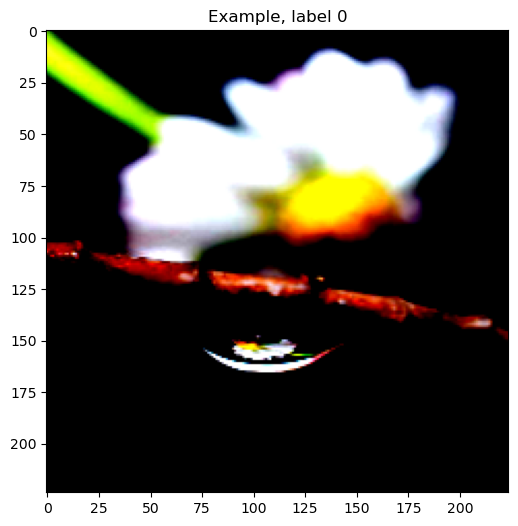

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 224, 224])


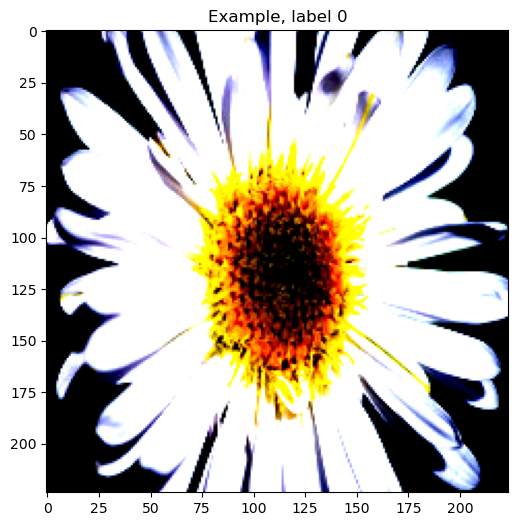

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 224, 224])


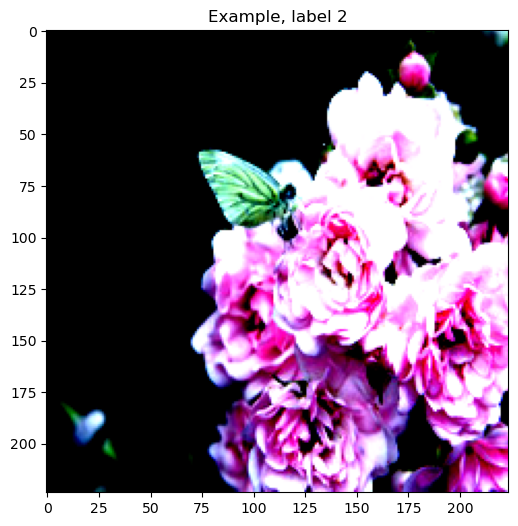

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 224, 224])


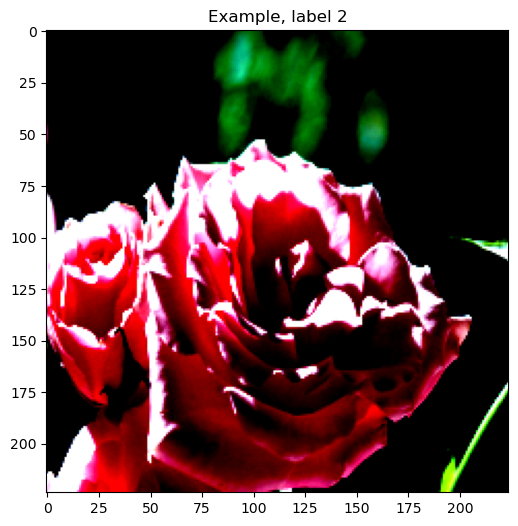

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 224, 224])


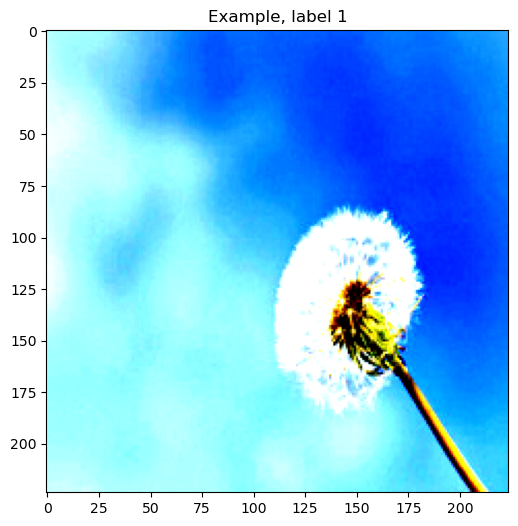

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=0,
    pin_memory=False,
    shuffle=True
)
torch.cuda.empty_cache()

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)


show_model_input(dataset = train_dataloader) 

# Model

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class TinyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        def block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1, bias=False),
                nn.GroupNorm(16, cout),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32),    # 224 -> 112
            block(32, 64),   # 112 -> 56
            block(64, 128),  # 56 -> 28
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)  # logits   
        )

    def forward(self, x):
        x = self.features(x) #.unsqueeze(0)
        x = self.pool(x)
        return self.head(x)

    @torch.no_grad()
    def get_probabilities(self, x):
        logits = self.forward(x)
        probs = torch.softmax(logits, dim=1)  # shape [N, C]
        return probs

model_base = TinyCNN(num_classes=5).to(device)

In [40]:
train_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [41]:
model_base(train_dataset[0][0].unsqueeze(0).to(device)) #

tensor([[-0.3905,  0.4593, -0.4264, -1.0667,  0.2467]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [42]:
model_base.get_probabilities(train_dataset[0][0].unsqueeze(0).to(device))

tensor([[0.1492, 0.3131, 0.1825, 0.0799, 0.2752]], device='cuda:0')

# Model training

In [43]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:                   # x:[N,3,224,224], y:[N]
        x, y = x.to(device), y.to(device).long()
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

@torch.inference_mode()
def evaluate(model, loader, device):
    model.eval()
    total_loss = total_correct = total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device).long()
        logits = model(x)
        total_loss += F.cross_entropy(logits, y).item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

In [44]:
@dataclass
class TrainingParams:
    train_dataloader: torch.utils.data.DataLoader
    val_dataloader: torch.utils.data.DataLoader
    optimizer: Optimizer
    device: str
    n_epochs: int
    early_stopping: bool

class Experiment:
    def __init__(self, model: nn.Module, params: TrainingParams):
        self.model = model
        self.params = params
        self.tr_loss_data = []
        self.tr_acc_data = []
        self.va_loss_data = []
        self.va_acc_data = []

    def _check__early_stopping(self, epoch: int):
        if epoch > 5 and self.va_loss_data[-1] > self.va_loss_data[-2] > self.va_loss_data[-3] > self.va_loss_data[-4]:
            print("Early stopping")
            return True
        else:
            return False
        
    def run(self):
        for epoch in range(self.params.n_epochs):
            tr_loss, tr_acc = train_one_epoch(
                self.model, 
                self.params.train_dataloader, 
                self.params.optimizer, 
                self.params.device
            )
            va_loss, va_acc = evaluate(
                self.model, 
                self.params.val_dataloader, 
                self.params.device
            )

            self.tr_loss_data.append(tr_loss)
            self.tr_acc_data.append(tr_acc)
            self.va_loss_data.append(va_loss)
            self.va_acc_data.append(va_acc)
            
            print(f"epoch {epoch+1:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
            if self._check__early_stopping(epoch):
                break

    def get_learning_dynamics(self) -> pd.DataFrame:
        df = pd.DataFrame(data = {
            "tr_loss":self.tr_loss_data,
            "tr_acc":self.tr_acc_data,
            "va_loss":self.va_loss_data,
            "va_acc":self.va_acc_data,
        })
        return df

    def plot_results(self):
        df = self.get_learning_dynamics()
        df\
            .plot(
                y = ["tr_loss", "va_loss"],
                grid = True,
                figsize = (9, 4),
                title = "Loss"
            )
        plt.show()

        df\
            .plot(
                y = ["tr_acc", "va_acc"],
                grid = True,
                figsize = (9, 4),
                title = "Accuracy"
            )
        plt.show()



In [45]:
model_base = TinyCNN(num_classes=5).to(device)

# ----- usage -----
params = TrainingParams(
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    optimizer = AdamW(model_base.parameters(), lr=3e-4, weight_decay=1e-2),
    device=device,
    n_epochs = 50,
    early_stopping = True
)


exp = Experiment(model_base, params)
exp.run()

epoch 01 | train loss 1.4007 acc 0.406 | val loss 1.2364 acc 0.465
epoch 02 | train loss 1.2117 acc 0.476 | val loss 1.2154 acc 0.477
epoch 03 | train loss 1.1415 acc 0.504 | val loss 1.0840 acc 0.565
epoch 04 | train loss 1.0673 acc 0.573 | val loss 1.0479 acc 0.549
epoch 05 | train loss 1.0469 acc 0.581 | val loss 1.0676 acc 0.548
epoch 06 | train loss 0.9865 acc 0.618 | val loss 0.9984 acc 0.587
epoch 07 | train loss 0.9571 acc 0.621 | val loss 0.9655 acc 0.583
epoch 08 | train loss 0.9459 acc 0.629 | val loss 1.0514 acc 0.558
epoch 09 | train loss 0.9360 acc 0.629 | val loss 0.9393 acc 0.625
epoch 10 | train loss 0.9027 acc 0.637 | val loss 0.9005 acc 0.670
epoch 11 | train loss 0.8676 acc 0.659 | val loss 0.9061 acc 0.636
epoch 12 | train loss 0.8732 acc 0.658 | val loss 0.9056 acc 0.682
epoch 13 | train loss 0.8657 acc 0.655 | val loss 0.8600 acc 0.684
epoch 14 | train loss 0.8368 acc 0.669 | val loss 0.8476 acc 0.671
epoch 15 | train loss 0.8225 acc 0.683 | val loss 0.8685 acc 0

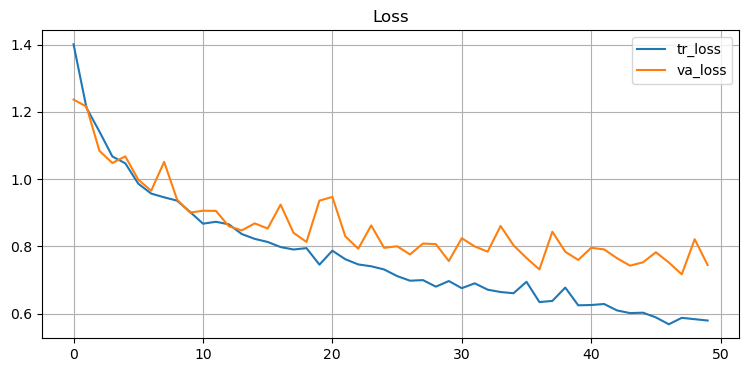

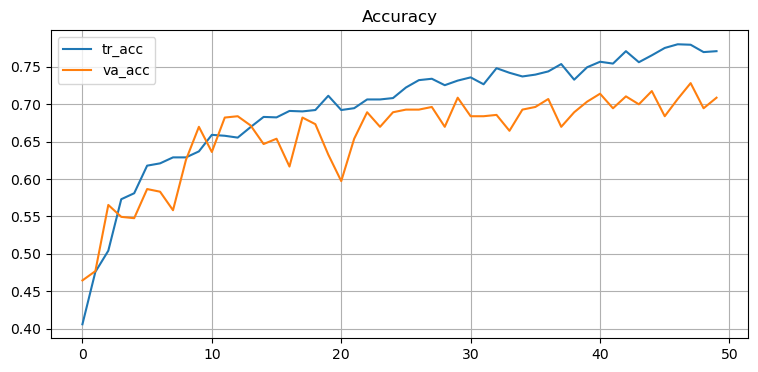

In [49]:
exp.plot_results()

# Model evaluation

In [50]:
def eval_result(pred, y_test, names: list):
    assert y_test.shape == pred.shape, f'{y_test.shape} =/= {pred.shape}'
    print(classification_report(y_test, pred, target_names = names))
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, pred), 
                     columns = [f'Predicted {name}' for name in names],
                     index = [f'Actual {name}' for name in names])
    display(conf_matrix)
    display(np.round(conf_matrix / len(y_test), 3).style.format('{:.1%}'))

def evaluate_model(model:nn.Module, dataloader: torch.utils.data.DataLoader, class_names: list):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): 
        for X_test, y_test in tqdm(dataloader):
            X_test, y_test = X_test.to(device), y_test.unsqueeze(dim = 1).to(device)
            y_logits_test = model(X_test)
            preds = np.argmax(torch.sigmoid(y_logits_test).cpu(), axis = 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())
    
    # Convert to numpy arrays
    y_test = np.array(all_labels).reshape(-1)
    pred = np.array(all_preds)
    
    # Call the evaluation function
    eval_result(pred, y_test, class_names)

In [51]:
evaluate_model(model_base, test_dataloader, class_names)

100%|██████████| 550/550 [00:02<00:00, 183.93it/s]

              precision    recall  f1-score   support

       daisy       0.86      0.69      0.76       106
   dandelion       0.89      0.70      0.78       132
        rose       0.55      0.68      0.61        99
   sunflower       0.71      0.89      0.79        96
       tulip       0.69      0.71      0.70       117

    accuracy                           0.73       550
   macro avg       0.74      0.73      0.73       550
weighted avg       0.75      0.73      0.73       550



,Predicted daisy,Predicted dandelion,Predicted rose,Predicted sunflower,Predicted tulip
Actual daisy,73,9,15,6,3
Actual dandelion,3,93,12,17,7
Actual rose,4,0,67,4,24
Actual sunflower,3,1,4,85,3
Actual tulip,2,2,23,7,83


,Predicted daisy,Predicted dandelion,Predicted rose,Predicted sunflower,Predicted tulip
Actual daisy,13.3%,1.6%,2.7%,1.1%,0.5%
Actual dandelion,0.5%,16.9%,2.2%,3.1%,1.3%
Actual rose,0.7%,0.0%,12.2%,0.7%,4.4%
Actual sunflower,0.5%,0.2%,0.7%,15.5%,0.5%
Actual tulip,0.4%,0.4%,4.2%,1.3%,15.1%


In [52]:
# Save the trained model
import torch
import os

# Create a models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model state dict (recommended)
torch.save(model_base.state_dict(), 'models/flower_classifier_state_dict.pth')

# Save the complete model (alternative)
torch.save(model_base, 'models/flower_classifier_complete.pth')

# Save additional training information
model_info = {
    'model_state_dict': model_base.state_dict(),
    'class_names': class_names,
    'num_classes': len(class_names),
    'model_architecture': 'TinyCNN',
    'image_size': (224, 224),
    'training_epochs': len(exp.tr_loss_data),
    'final_train_acc': exp.tr_acc_data[-1],
    'final_val_acc': exp.va_acc_data[-1]
}

torch.save(model_info, 'models/flower_classifier_with_info.pth')

print("Model saved successfully!")
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

Model saved successfully!
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
